In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

# Import files

In [2]:
# --- overlay sample
#file1 = '../rootfiles/checkout_prodgenie_numi_overlay_run1.root'
#file2 = '../rootfiles/output.root' # new sample generated using the unified workflow
#file3 = '../rootfiles/checkout_prodgenie_numi_overlay_run1_OFFSETFIXED2.root'


# --- intrinsic nue sample
file1 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'
file2 = '../rootfiles/checkout_intrinsic_nue_numi_run1_particle_flow.root' # new sample generated using the unified workflow
file3 = '../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1_OFFSETFIXED2.root'

# Calculate number of entries and POT

In [3]:
kine_vars   = ['kine_reco_Enu','kine_pio_vtx_dis','kine_pio_energy_1']
bdt_vars    = ['numu_cc_flag','nue_score']
pot_vars    = ['pot_tor875']
pfeval_vars = ['truth_corr_nuvtxX','truth_corr_nuvtxY','truth_corr_nuvtxZ','reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ']
eval_vars   = ['truth_isCC','truth_nuPdg','truth_vtxInside','weight_spline', 'weight_cv',
               'match_found', 'stm_eventtype', 'stm_lowenergy', 'stm_LM', 'stm_TGM', 'stm_STM', 'stm_FullDead','stm_clusterlength',
               'truth_energyInside', 'match_completeness_energy']

# --- variables calculated by me
extra_vars  = ['cos_theta'] 


def create_dataframe(file, family):

    # --- import trees and variables
    T_pot = uproot.open(file)['wcpselection/T_pot']
    df_pot = T_pot.pandas.df(pot_vars, flatten=False)
    print('T_pot     %i entries' % len(df_pot))
    
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    df_KINE = T_KINE.pandas.df(kine_vars, flatten=False)
    print('T_kine    %i entries' % len(df_KINE))

    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    df_BDT = T_BDT.pandas.df(bdt_vars, flatten=False)
    print('T_BDT     %i entries' % len(df_BDT))
            
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    df_PFeval = T_PFeval.pandas.df(pfeval_vars, flatten=False)
    print('T_PFeval  %i entries' % len(df_PFeval))

    T_eval = uproot.open(file)['wcpselection/T_eval']
    df_eval = T_eval.pandas.df(eval_vars, flatten=False)
    print('T_eval    %i entries' % len(df_eval))

    # --- merge dataframes
    df = pd.concat([df_KINE, df_PFeval, df_BDT, df_eval], axis=1)

    # --- calculate POT
    POT = sum(df_pot.pot_tor875)

    return df, POT

print('%s' % file1)
df_file1, POT1 = create_dataframe(file1,'MC')
print('POT       %.2e' % POT1)
print('Entries   %i\n' % len(df_file1))

print('%s' % file2)
df_file2, POT2 = create_dataframe(file2,'MC')
print('POT       %.2e' % POT2)
print('Entries   %i\n' % len(df_file2))

print('%s' % file3)
df_file3, POT3 = create_dataframe(file3,'MC')
print('POT       %.2e' % POT3)
print('Entries   %i\n' % len(df_file3))

../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root
T_pot     15581 entries
T_kine    71958 entries
T_BDT     71958 entries
T_PFeval  71958 entries
T_eval    71958 entries
POT       1.35e+22
Entries   71958

../rootfiles/checkout_intrinsic_nue_numi_run1_particle_flow.root
T_pot     26013 entries
T_kine    125501 entries
T_BDT     125501 entries
T_PFeval  125501 entries
T_eval    125501 entries
POT       5.25e+07
Entries   125501

../rootfiles/checkout_prodgenie_numi_intrinsic_nue_overlay_run1_OFFSETFIXED2.root
T_pot     21033 entries
T_kine    98298 entries
T_BDT     98298 entries
T_PFeval  98298 entries
T_eval    98298 entries
POT       1.84e+22
Entries   98298



# Plot difference between file2-file1

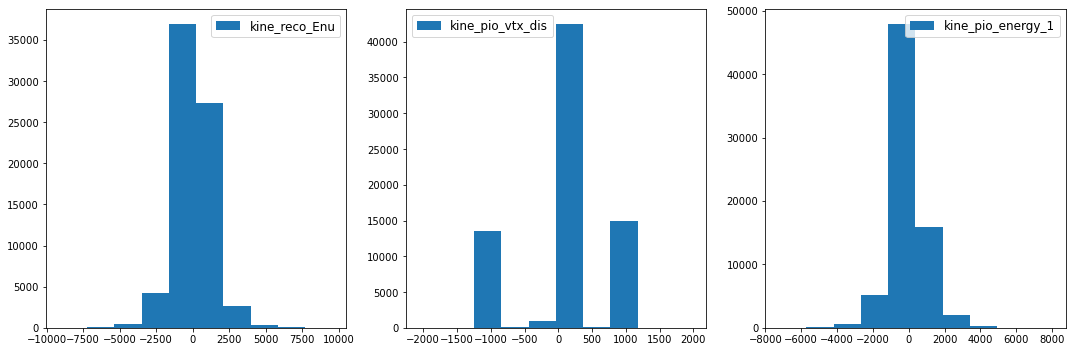

In [4]:
legend_size = 12

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2.kine_reco_Enu-df_file1.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2.kine_pio_vtx_dis-df_file1.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2.kine_pio_energy_1-df_file1.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()

# Plot the difference between file2-file3

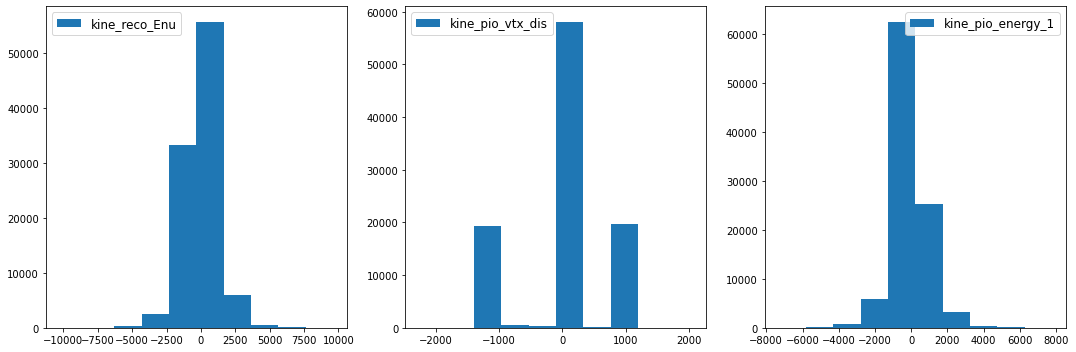

In [5]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.hist(df_file2.kine_reco_Enu-df_file3.kine_reco_Enu, label='kine_reco_Enu')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(132)
plt.hist(df_file2.kine_pio_vtx_dis-df_file3.kine_pio_vtx_dis, label='kine_pio_vtx_dis')
plt.legend(loc='best', prop={'size': legend_size})

plt.subplot(133)
plt.hist(df_file2.kine_pio_energy_1-df_file3.kine_pio_energy_1, label='kine_pio_energy_1')
plt.legend(loc='best', prop={'size': legend_size})

plt.tight_layout()